In [1]:
# Importing relevant libraries
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, Activation, Flatten, ReLU, Dense, Reshape
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import pickle

In [2]:
cd D:/Study/Internship-E5/image similarity model/Rings-1

D:\Study\Internship-E5\image similarity model\Rings-1


In [3]:
def get_features(pathdir):
    '''
    Get image features
    Args : 
        pathdir -> Path to directory of images
    '''
    main = []
    for path in os.listdir(pathdir):
        img = image.load_img(pathdir+path, target_size=(256, 256))
        img = image.img_to_array(img)
        img_arr = np.expand_dims(img, axis=-1)
        main.append(img_arr)
    return main

In [4]:
img_data = get_features('D:/Study/Internship-E5/image similarity model/Rings-1/Data/')
val_split = 0.2
train_ds, val_ds = img_data[int(val_split*len(img_data)):], img_data[:int(val_split*len(img_data))]
print("There are {} training images and {} images for validation".format(len(train_ds), len(val_ds)))

There are 3845 training images and 961 images for validation


In [5]:
def create_autoencoder_model(height, width, channels, latent_image_size=32):
    '''
    Function to build the model
    Args : 
        height -> Height of image (int)
        width -> Width of image (int)
        channels -> 3 (RGB) or 4 (RGBA) or 1 (Grayscale)
        latent_image_size -> The latent image size of encoder result (int)
    Returns :
        Autoencoder Tensorflow Keras model
    '''
    
    input_shape = (height, width, channels)

    ## Building Encoder Model

    # Feed the input to the model
    inputs = Input(shape=input_shape)

    # Feeding to Convolutional network and applying Batch Normalization (et al. Ioffe and Szegedy, 2015)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)     

    # Generating the latent vectors after flattening
    enc_size = K.int_shape(x)
    x = Flatten()(x)
    encoder = Dense(latent_image_size, name='encoder')(x)


    ## Building Decoder Model

    # Feed the output of the Encoder to the Decoder model
    x = Dense(np.prod(enc_size[1:]))(encoder)
    x = Reshape((enc_size[1], enc_size[2], enc_size[3]))(x)

    # Feeding to Convolutional network and applying Batch Normalization 
    # in reverse order as it is decoder. Conv2DTranspose applies Convolutional network
    # while Upsampling simultaneously
    x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)

    # Feeding it to another Conv2DTranspose to recover original Input shape
    x = Conv2DTranspose(filters=channels, kernel_size=(3, 3), padding='same')(x)
    decoder = Activation('sigmoid', name='decoder')(x)

    # Constructing the Autoencoder Model
    autoencoder = Model(inputs, decoder, name='autoencoder')

    return autoencoder

In [6]:
def train_model(train, val, epochs=30, lr=1e-3, batch_size=8):
    '''
    Function to train the Autoencoder model
    Args : 
        train : Training Data (tf.Tensor)
        val : Validation Data (tf.tensor)
        epochs : Number of epochs (int)
        lr : Learning Rate (float)
        batch_size : Batch Size (int)
    '''

    print("Creating model...")
    model = create_autoencoder_model(256, 256, 3)
    model.compile(optimizer=Adam(lr=lr), loss="mse")

    print("Autoencoder model structure")
    print(model.summary())

    # Train the model
    history = model.fit(
        train, train,
        validation_data=(val, val),
        epochs=epochs,
        batch_size=batch_size)

    # Plot the curves
    plt.figure()
    plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig("accerr.png")

    # Saving the model in HDF5 format
    model.save('autoencoder.h5', save_format="h5")

In [7]:
train_ds, val_ds = np.array(train_ds), np.array(val_ds)
train_ds, val_ds = train_ds.astype('float32') / 255.0, val_ds.astype('float32') / 255.0
train_ds, val_ds = train_ds.squeeze(), val_ds.squeeze()

print("Shape of train_ds : {}, val_ds : {}".format(train_ds.shape, val_ds.shape))

Shape of train_ds : (3845, 256, 256, 3), val_ds : (961, 256, 256, 3)


Creating model...
Autoencoder model structure
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   


D:\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 encoder (Dense)             (None, 32)                1048608   
                                                                 
 dense (De

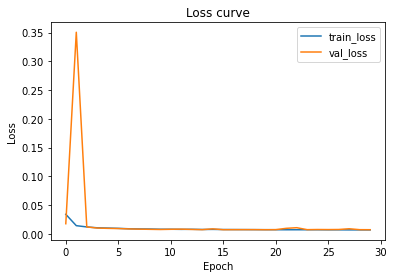

In [8]:
train_model(train_ds, val_ds)

In [9]:
def generate_features(train):
    '''
    Function to create feature vectors for indexing
    Args :
        train : Training images
    '''
    
    print("Loading model...")
    model = load_model("autoencoder.h5")

    # Creating the Encoder model of the Autoencoder
    encoder = Model(inputs=model.input, outputs=model.get_layer("encoder").output)

    # Generating the respective feature of images in latent vector spaces
    print("Creating the feature vectors...")
    features = encoder.predict(train)

    # Hashing the indexes to their respective latent features
    indices = list(range(0, train.shape[0]))
    data = {"indices": indices, "features": features}

    try:
        f = open("latentvectors.pkl", "wb")
        f.write(pickle.dumps(data))
        f.close()
        print("Featurs and images indexed succesfully")
    except Exception as e:
        print("Error : {}".format(e))

In [12]:
generate_features(train_ds)

Loading model...
Creating the feature vectors...
Featurs and images indexed succesfully


In [13]:
index = pickle.loads(open("D:/Study/Internship-E5/image similarity model/Rings-1/latentvectors.pkl", "rb").read())
print(index['indices'][0], " : ", index['features'][0])

0  :  [  99.448746    64.435425  -205.36893    226.91281    -59.811623
  250.43224     86.66174    -58.780823    -7.0488224 -126.50043
 -717.1416     153.03845    201.49794   -152.59285     35.418106
  214.3136    -118.87062   -277.322       33.732395  -166.87933
   90.19089   -276.04843   -109.82806    -34.155903   -17.262854
   86.97866     48.804646    76.510574   177.35062    150.06485
 -254.14363    190.29794  ]


In [14]:
# This can be written in Pythonic format as 
def euclidean_distance(source, destination):
    '''
    Function to compute the Euclidean Distance
    Args : 
        source -> Vector
        destination -> Vector
    Returns :
        Euclidean distance -> float
    '''
    return np.linalg.norm(source - destination)

In [15]:
def get_most_similar_images(search, indices, nearest):
    '''
    Function to find the points with least Euclidean Distance
    Args : 
        search -> Source vector
        indices -> Destination vectors
        N -> Number of results to return
    '''
    result = []
    for i in range(len(indices['indices'])):
        result.append((euclidean_distance(search, indices['features'][i]), i))
    
    # Each value in result is in form of (distance, index)    
    return sorted(result)[:nearest]

In [16]:
%matplotlib inline

def get_similar_images(test_sample, train_ds, val_ds, N):
        '''
        Function to get N images similar to the current image
        Args :
            test_sample -> Indices of images to search the similar images for
            train_ds -> Array containing original trained images
            val_ds -> Array containing untrained images
            N -> Number of images to search for (N)
        '''
        # Load model
        model = load_model('autoencoder.h5')
        indices = pickle.loads(open('latentvectors.pkl', 'rb').read())

        # Get the encoder part of the autoencoder
        encoder = Model(inputs=model.input, outputs=model.get_layer('encoder').output)

        # Get the latent features of the sample
        sample_features = encoder.predict(val_ds)

        # Iterate over the required indices
        for i in test_sample:
            images = []

            # Get the indices of most similar N images
            search_results = get_most_similar_images(sample_features[i], indices, nearest=N)

            for dist, ind in search_results:
                img = (train_ds[ind]*255).astype('uint8')
                images.append(np.dstack([img]))
            
            # Displaying image to search
            print("Searching for this image : ")
            search_img = (val_ds[i]*255).astype("uint8")
            plt.imshow(search_img)
            plt.show()

            # Displaying resultant images
            print("Images most similar to the above image are : ")
            fig = plt.figure(figsize=(10, 16))

            for j in range(len(images)):
              fig.add_subplot(N // 3 + 1, 3, j + 1)  # Shift the subplot index by 1 to make space for the search image
              plt.imshow(images[j])
              plt.title("Resultant Image")

            plt.tight_layout()  # Adjust the spacing between subplots
            plt.show()

Searching for this image : 


Images most similar to the above image are : 


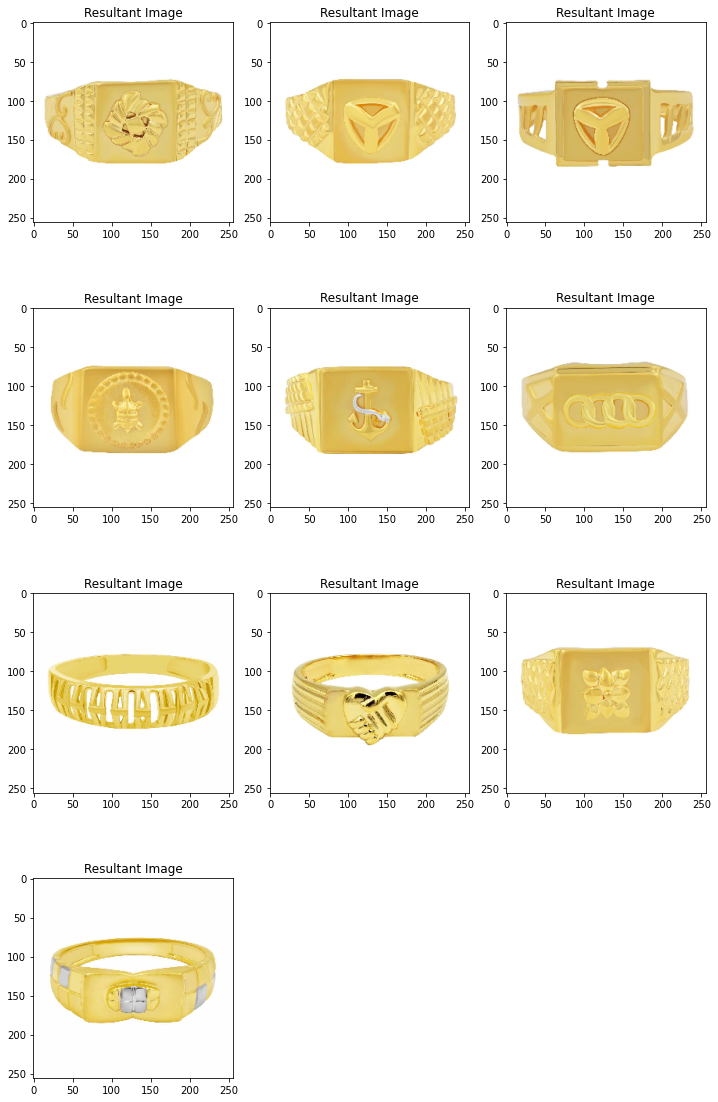

Searching for this image : 


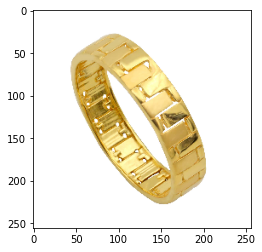

Images most similar to the above image are : 


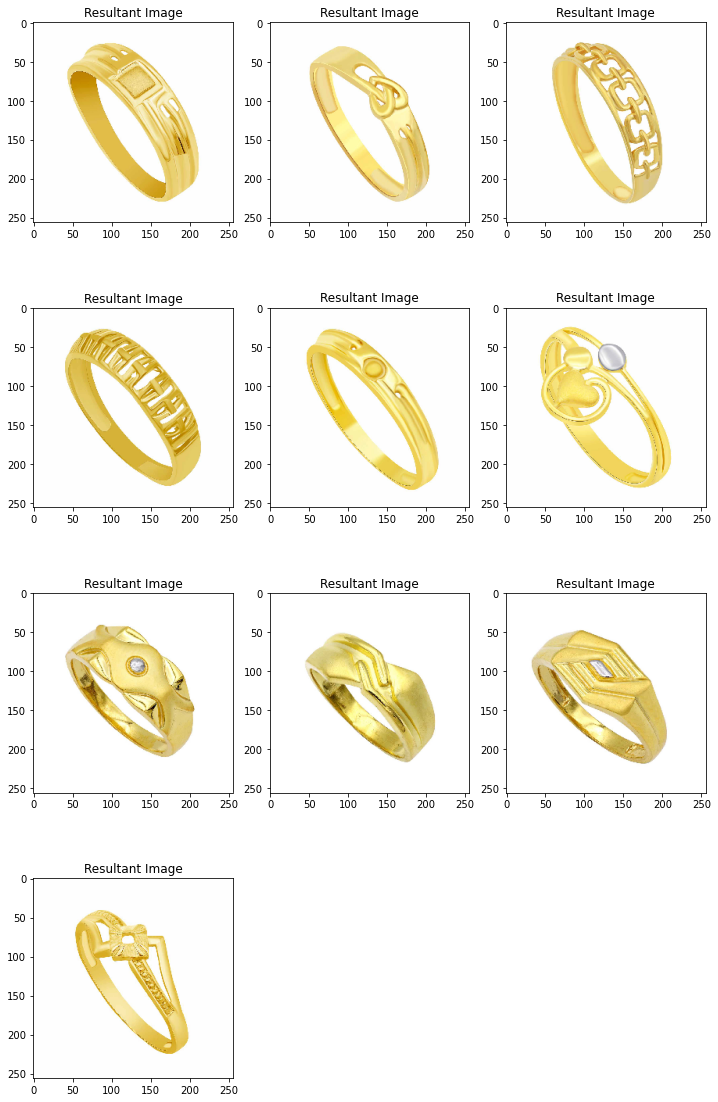

In [17]:
# Let's choose random indices from validation set to get their similar images
get_similar_images([100, 54], train_ds, val_ds, 10)

Searching for this image : 


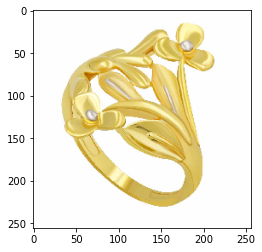

Images most similar to the above image are : 


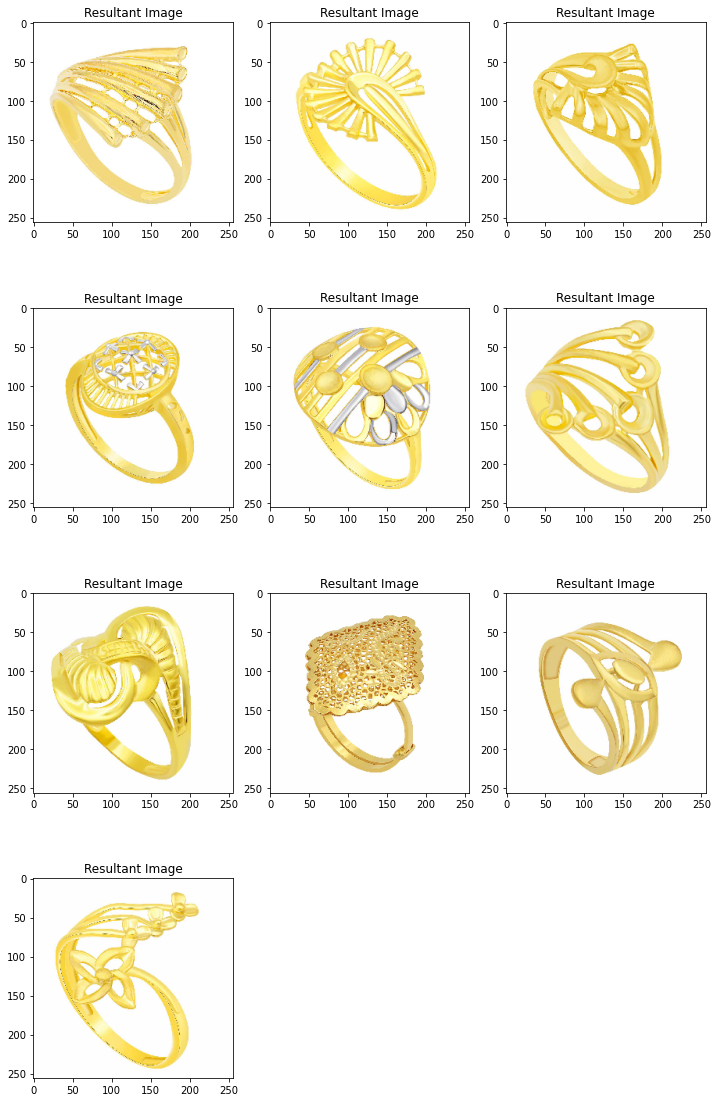

Searching for this image : 


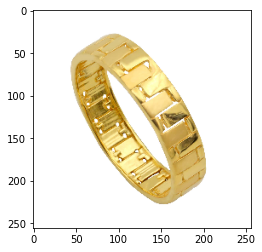

Images most similar to the above image are : 


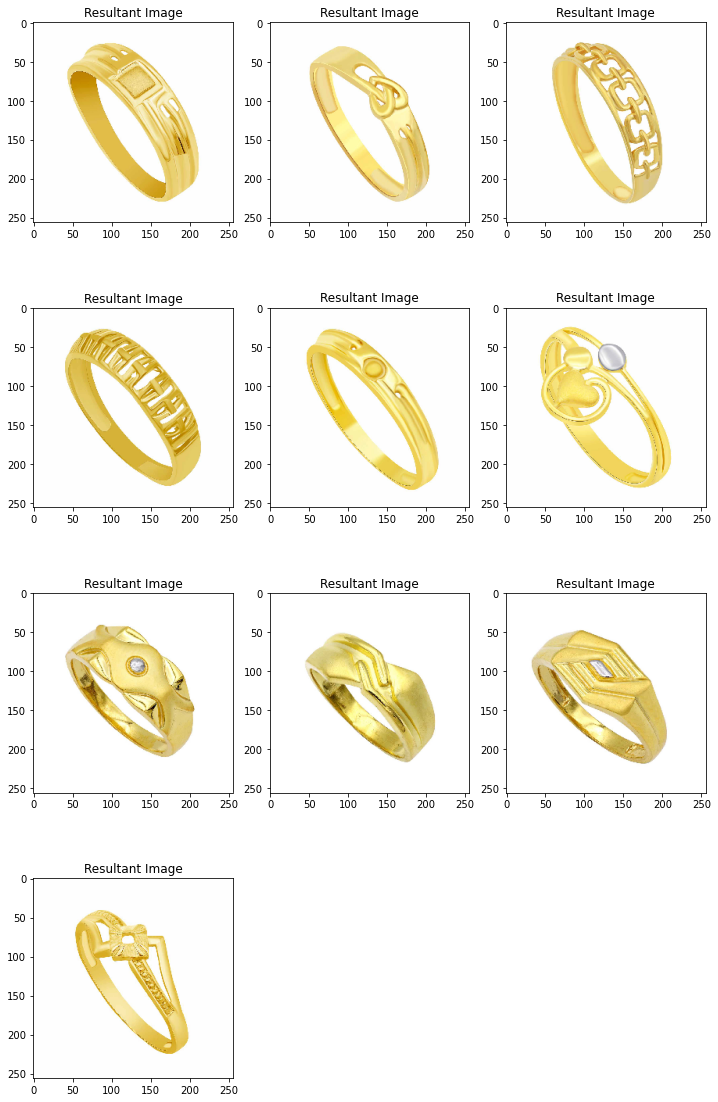

In [18]:
get_similar_images([300, 54], train_ds, val_ds, 10)

In [19]:
def get_similar_images(input_image, train_ds, N):
    '''
    Function to get N images similar to the input image
    Args :
        input_image -> Image to search similar images for
        train_ds -> Array containing original trained images
        N -> Number of images to search for (N)
    '''
    # Load model
    model = load_model('autoencoder.h5')
    indices = pickle.loads(open('latentvectors.pkl', 'rb').read())

    # Get the encoder part of the autoencoder
    encoder = Model(inputs=model.input, outputs=model.get_layer('encoder').output)

    # Preprocess the input image
    input_image = image.load_img(input_image, target_size=(256, 256))
    input_image = image.img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)
    input_image = input_image.astype('float32') / 255.0

    # Get the latent features of the input image
    input_features = encoder.predict(input_image)

    # Get the indices of most similar N images
    search_results = get_most_similar_images(input_features[0], indices, nearest=N)

    # Display the input image
    print("Input Image:")
    plt.imshow(input_image[0])
    plt.axis('off')
    plt.show()

    # Display the resultant images
    print("Similar Images:")
    fig = plt.figure(figsize=(10, 16))
    for i, (dist, ind) in enumerate(search_results):
        img = (train_ds[ind]*255).astype('uint8')
        fig.add_subplot(N // 3 + 1, 3, i + 1)  # Shift the subplot index by 1 to make space for the input image
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()


Input Image:


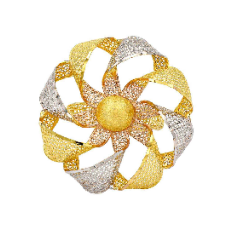

Similar Images:


In [21]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Rings-1/test.jpg', train_ds, N=10)

In [35]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Rings-1/Data/GRN04804L.jpg', train_ds, N=10)

Input Image:


Similar Images:


Input Image:


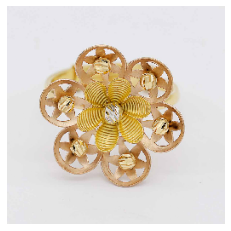

Similar Images:


In [36]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Rings-1/Data/GRN04653L.jpg', train_ds, N=10)

Input Image:


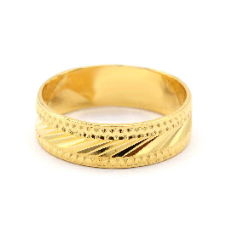

Similar Images:


In [64]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Rings-1/Data/GRB00325M.jpg', train_ds, N=10)

Input Image:


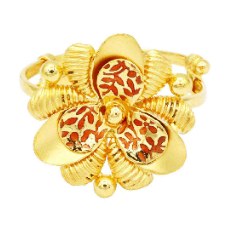

Similar Images:


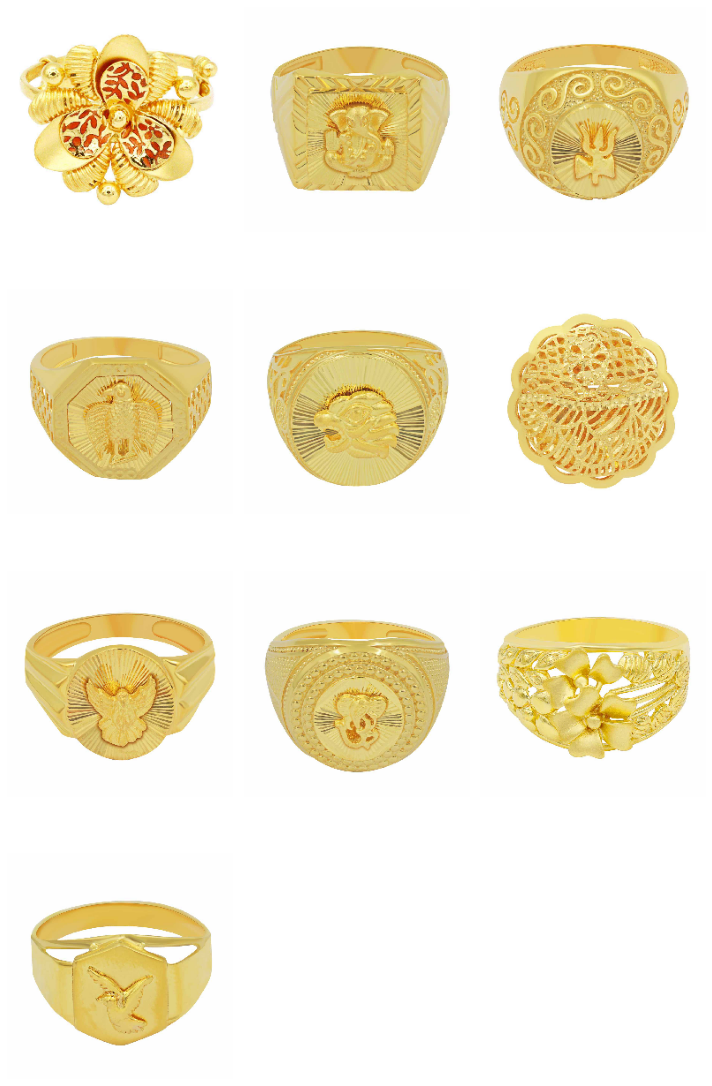

In [66]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Rings-1/Data/GRN00021.jpg', train_ds, N=10)

Input Image:


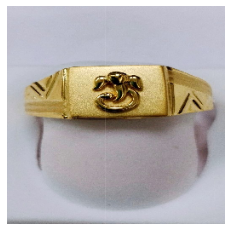

Similar Images:


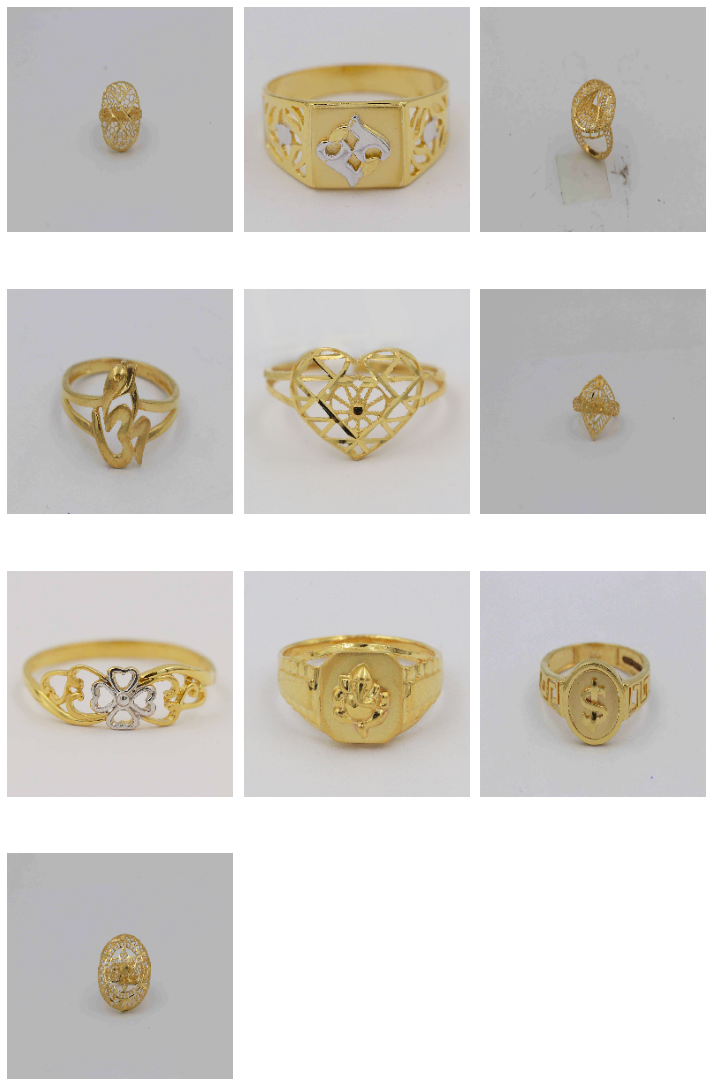

In [25]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Camera Images/Camera Images/GRN01957M.jpg', train_ds, N=10)

Input Image:


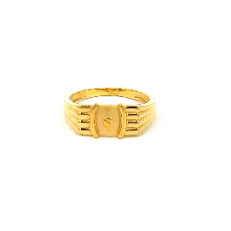

Similar Images:


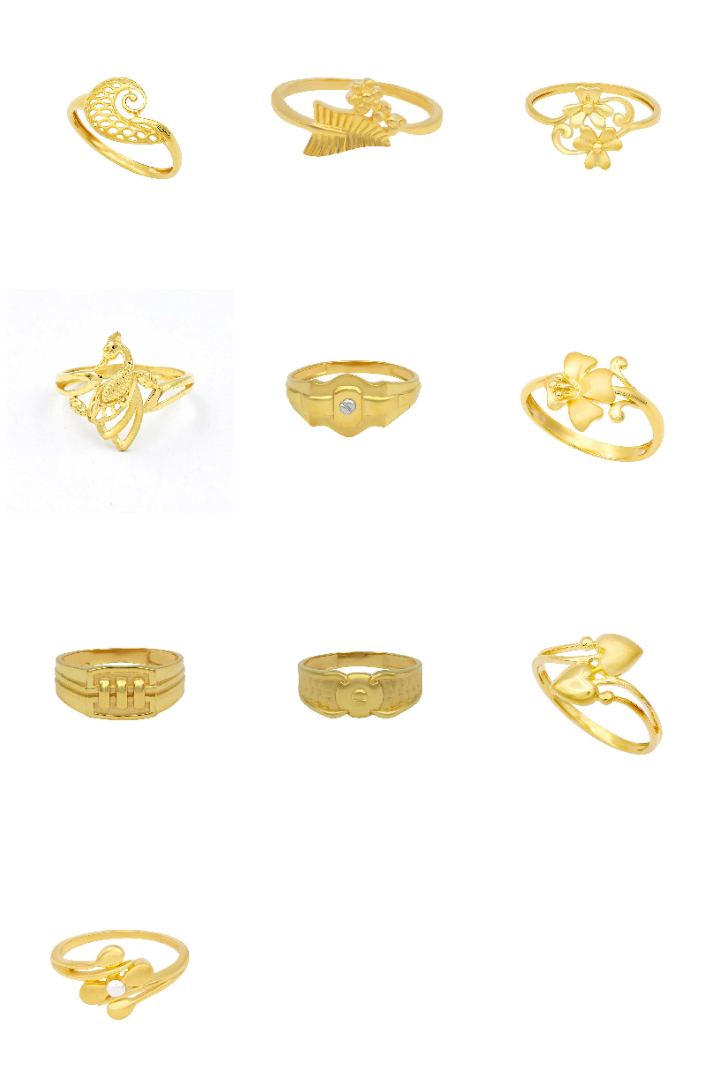

In [30]:
get_similar_images('D:/Study/Internship-E5/image similarity model/GLB-images-20230411T030920Z-001/GLB-images/Untitled Product 5_1.jpg', train_ds, N=10)

Input Image:


Similar Images:


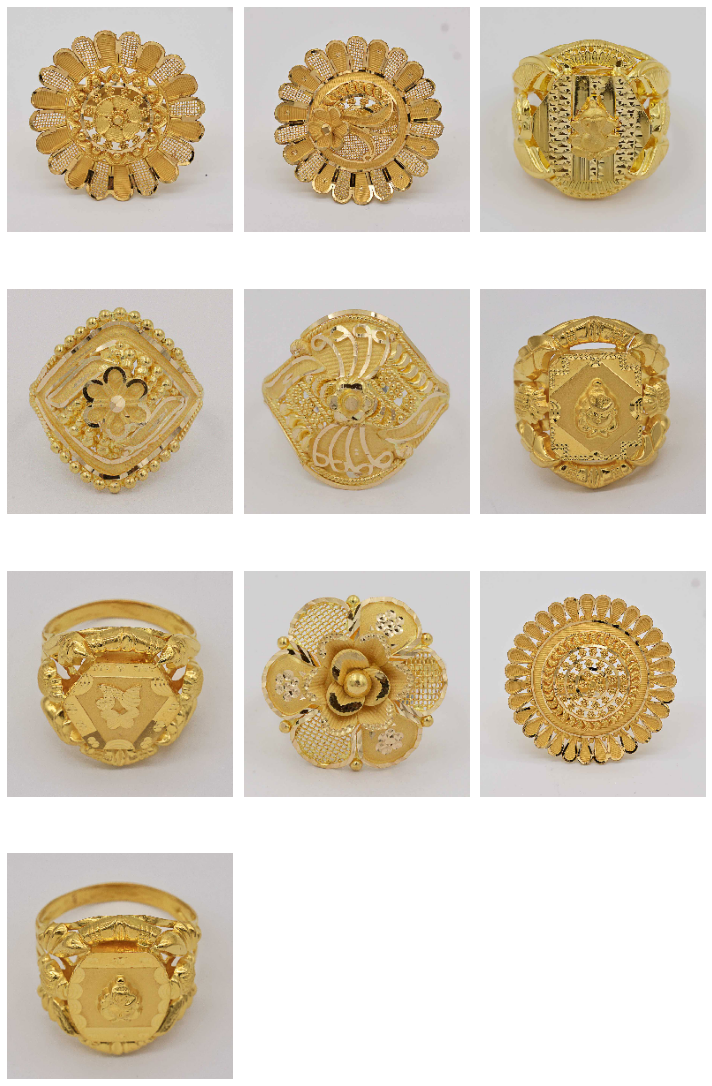

In [53]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Camera Images/Camera Images/GRN01064_2.jpg', train_ds, N=10)

Input Image:


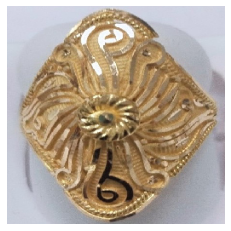

Similar Images:


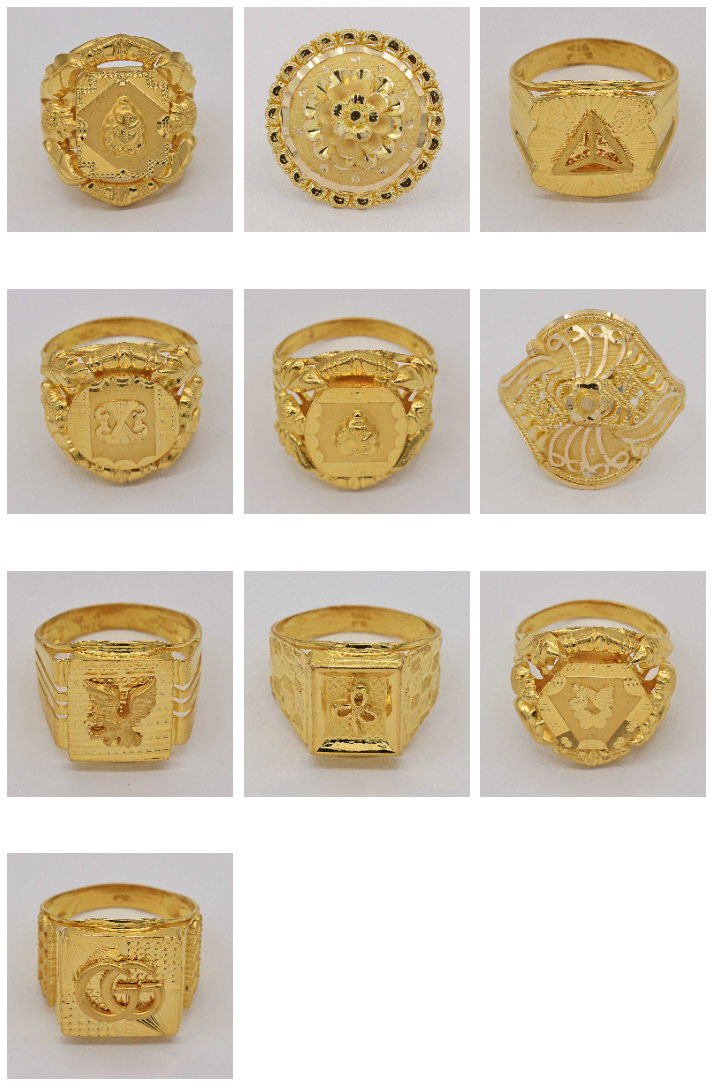

In [69]:
get_similar_images('D:/Study/Internship-E5/image similarity model/Camera Images/Camera Images/GRN01046_2.jpg', train_ds, N=10)